In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

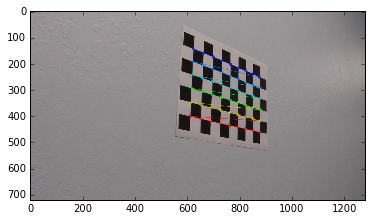

In [4]:
for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

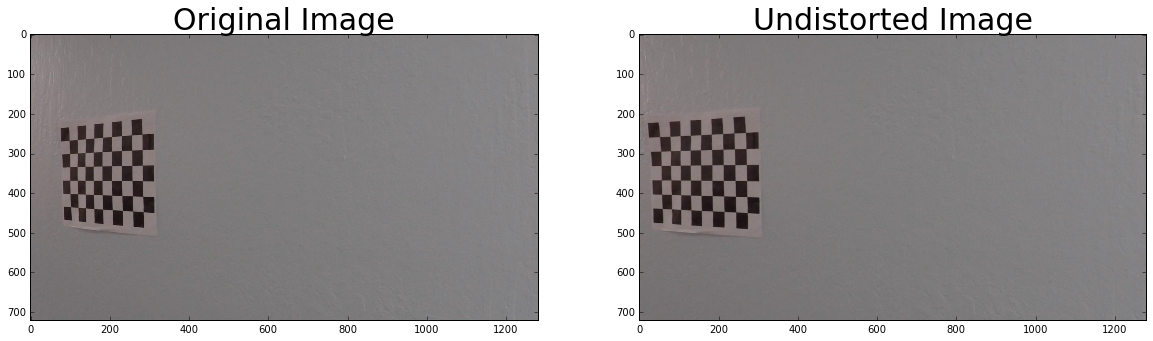

In [5]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Apply the distortion correction to the raw image.

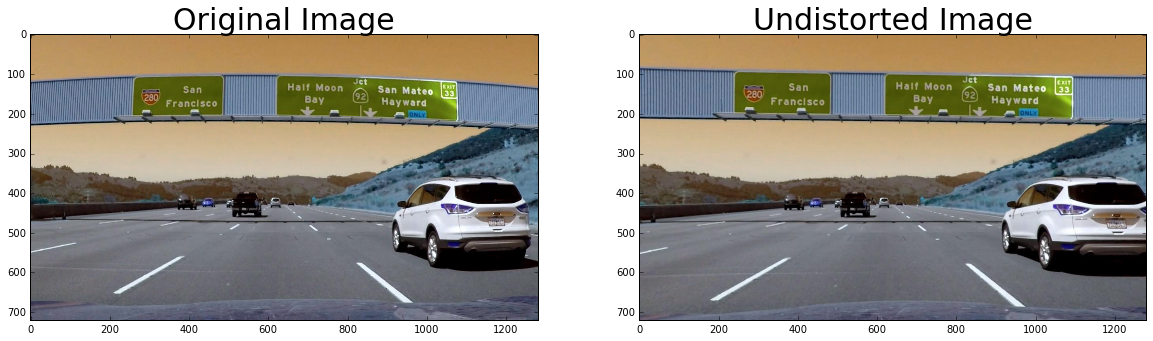

In [6]:
raw = cv2.imread("test_images/quiz.png")

corrected_raw = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(corrected_raw)
ax2.set_title('Undistorted Image', fontsize=30)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("Error: orient must be either x or y.")
    
    # 3) Take the absolute value of the derivative or gradient
    abs_derivative = np.absolute(derivative)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # So there are 1s where #s are within our thresholds and 0s otherwise.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 6) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 7) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary

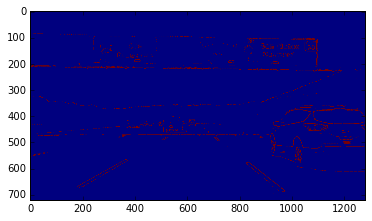

In [8]:
image = corrected_raw

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined)

In [9]:
img = image

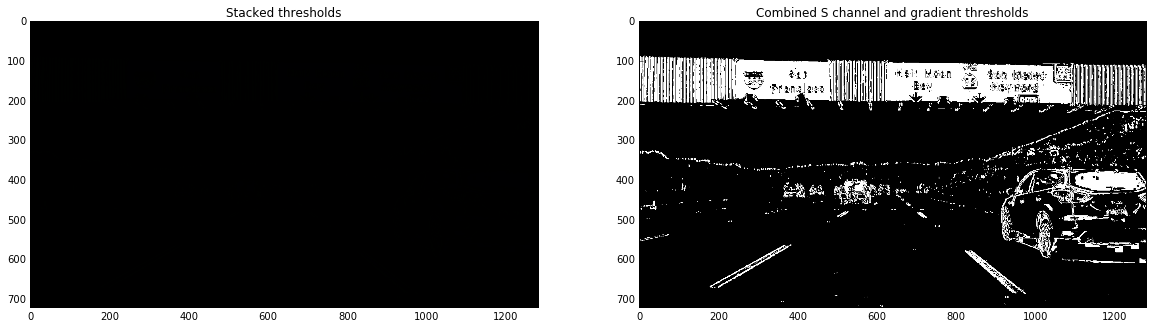

In [10]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [12]:
imshape = combined_binary.shape
print(imshape)

(720, 1280)


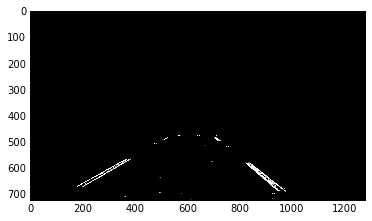

In [13]:
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

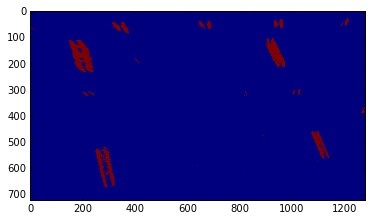

In [14]:
src = np.float32(
    [[0, 720],
     [550, 470],
     [700, 470],
     [720, 1280]])

dst = np.float32(
    [[200,720],
     [200,0],
     [900,0],
     [900,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

### 5. Detect lane pixels and fit to find lane boundary.

In [25]:
from scipy import signal

### Edit below so it only searches LHS or RHS of frame (LHS for left lane line, RHS for right lane line)

In [74]:
left_x_window_centres = []
right_x_window_centres = []
y_window_centres = []

/Users/jessica/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


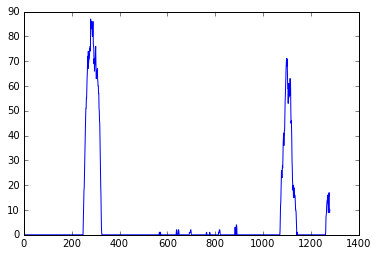

In [63]:
height = warped.shape[0]
half_frame = warped.shape[1] // 2
steps = 2
pixels_per_step = height / steps
medianfilt_kernel_size = 51

# for i in range(0):

i = 0
start = height - (i * pixels_per_step) 
end = start - pixels_per_step
histogram = np.sum(warped[end:start,:], axis=0)
plt.plot(histogram)

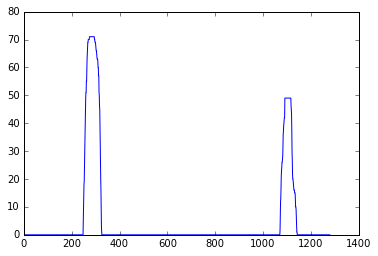

In [52]:
histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)
plt.plot(histogram_smooth)

In [73]:
left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1,5)))
right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1,5)))

print("Left Peaks: ", left_peaks)
print("Right Peaks (shifted by half frame): ", right_peaks)
left_peak = max(left_peaks)
right_peak = max(right_peaks) + half_frame
print("Max left peak: ", left_peak)
print("Max right peak: ", right_peak)

Left Peaks:  [259 261 265 267 270 275 276 294 296 300 304 309 313 315 316 317 318]
Right Peaks (shifted by half frame):  [433 438 446 447 452 453 476 477 478 480 495]
Max left peak:  318
Max right peak:  1135


In [79]:
# Add coordinates
left_x_window_centres.append(left_peak)
right_x_window_centres.append(right_peak)
y_window_centres.append((start + end) // 2)

In [59]:
# I want the bunch of pixels in the window though
# Not sure if this is what I need

def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixel inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

# User used with x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)


In [17]:
warped[warped.shape[0]/2

/Users/jessica/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

[ 0  0  0 ..., 11  9 10]


/Users/jessica/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


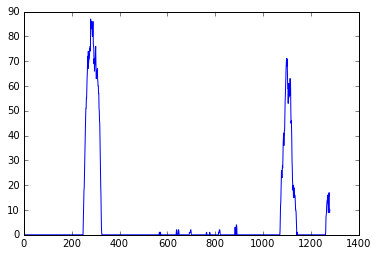

In [15]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
print(histogram)
peaks = [grad > 80 for grad in histogram]
# peaks: [False ... False True True ... False]
# print("Peaks: ", peaks)
plt.plot(histogram)

#### Place sliding window around line centers to find and follow the lines up to the top of the frame

In [ ]:
if not left_detected:
    left_x, left_y = histogram_lane_detection(
        frame, self.line_segments, (self.image_offset, frame.shape[1] // 2), h_window=7)
    left_x, left_y = outlier_removal(left_x, left_y)

Section reference: 
* https://github.com/pkern90/CarND-advancedLaneLines

### 6. Determine curvature of the lane and vehicle position with respect to center.

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


Further references:
* https://github.com/mohankarthik/CarND-AdvancedLaneLines-P4
* https://github.com/pkern90/CarND-advancedLaneLines